# Read NI DATA And Map to Allen Space

## Setup

### Imports

In [1]:
import os
from typing import List, Dict, Tuple, Any
import time

import numpy as np
from dotenv import load_dotenv
import nrrd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from src.core.utils import fs
from src.flatmap.utils.bridge import get_boundaries, get_isocortex_3d_projector, get_average_template_projection
from src.flatmap.utils.read_ni_output import get_marker_points_from_xml
from src.flatmap.ccf_streamlines.morphology import transform_coordinates_to_volume
from src.flatmap.utils.nb_utils import get_projection_images_from_dict, setup_main_plot, plot_boundaries
from src.flatmap.utils.nb_utils import expand_label_image, dilate_image, dilate_binary_image

In [2]:
# Load environment variables from .env file
if load_dotenv() is False:
    print("Failed to load .env file")

EXPERIMENT_DATA_DIR = os.getenv("CASE_FILE_DATA_DIR")
if EXPERIMENT_DATA_DIR is None:
    print("Failed to load CASE_FILE_DATA_DIR from .env file")

example_case_file_dir = os.path.join(EXPERIMENT_DATA_DIR, "working")
case_files = fs.find_in_dir_with_ext(example_case_file_dir, ".xml")
if len(case_files) == 0:
    print("No case files found in directory")

CASE_FILE_PATH = case_files[0]
ALLEN_DATA_DIR = os.getenv("ALLEN_ATLAS_FILES")

if ALLEN_DATA_DIR is None:
    print("Failed to load ALLEN_ATLAS_FILES from .env file")

ALLEN_ANNOTATION_PATH = os.path.join(ALLEN_DATA_DIR, "annotation_10.nrrd")

if os.path.exists(ALLEN_ANNOTATION_PATH) is False:\
    print(f"Failed to find allen annotation file: {ALLEN_ANNOTATION_PATH}")

In [3]:
print(f"Case file path: {CASE_FILE_PATH}")
print(f"Allen annotation path: {ALLEN_ANNOTATION_PATH}")

Case file path: D:/data/neuro/flatmap/experiments\working\2000_ChAT_rabies 6cases Cortex.xml
Allen annotation path: D:/data/neuro/Allen\annotation_10.nrrd


In [4]:
%%time
view_space_for_other_hemisphere = "side"
view_lookup_file="side"
proj_butterfly_slab = get_isocortex_3d_projector(view_lookup_file=view_lookup_file)
bf_left_boundaries, bf_right_boundaries = get_boundaries(view_lookup_file=view_lookup_file, view_space_for_other_hemisphere=view_space_for_other_hemisphere)
bf_projection_max = get_average_template_projection()

loading path information


100%|██████████| 344/344 [00:07<00:00, 47.06it/s]


loading path information


100%|██████████| 1016/1016 [00:07<00:00, 137.32it/s]


CPU times: total: 49.1 s
Wall time: 49.2 s


In [5]:
marker_points = get_marker_points_from_xml(CASE_FILE_PATH)

In [6]:
morphological_list = []
names = marker_points.keys()
volume_shape = (1320, 800, 1140)
factor_values = (-10, -10, 10)

for i, points in enumerate(marker_points.values()):
    tic = time.perf_counter()

    points_vals_copy = points.copy()

    points_vals_copy = np.floor(points_vals_copy / factor_values).astype(int)
    points_vals = points_vals_copy.copy()
    points_vals[:, 0] = points_vals_copy[:, 2]
    points_vals[:, 1] = points_vals_copy[:, 1]
    points_vals[:, 2] = points_vals_copy[:, 0]

    point_vol = transform_coordinates_to_volume(points_vals, resolution=(10, 10, 10))
    # point_vol = transform_coordinates_to_volume(points_vals, resolution=factor_values)

    morph_layers = proj_butterfly_slab.project_volume(point_vol, thickness_type="unnormalized")
    # morph_layers = proj_butterfly_slab.project_volume(point_vol, thickness_type="normalized_layers")
    morphological_list.append(morph_layers)
    toc = time.perf_counter()
    print(f"Finished in {toc - tic:0.4f} seconds")

Finished in 4.4835 seconds
Finished in 4.2868 seconds
Finished in 4.0898 seconds
Finished in 4.1512 seconds
Finished in 4.2127 seconds
Finished in 4.2478 seconds


In [7]:
morphological_dict = {
    "unnormalized": [],
    "normalized_layers": [],
    "normalized_full": []
}
names = marker_points.keys()
volume_shape = (1320, 800, 1140)
factor_values = (-10, -10, 10)

for i, points in enumerate(marker_points.values()):
    tic = time.perf_counter()

    points_vals_copy = points.copy()

    points_vals_copy = np.floor(points_vals_copy / factor_values).astype(int)
    points_vals = points_vals_copy.copy()
    points_vals[:, 0] = points_vals_copy[:, 2]
    points_vals[:, 1] = points_vals_copy[:, 1]
    points_vals[:, 2] = points_vals_copy[:, 0]

    point_vol = transform_coordinates_to_volume(points_vals, resolution=(1, 1, 1))
    # point_vol = transform_coordinates_to_volume(points_vals, resolution=factor_values)

    for thickness_type in morphological_dict.keys():
        morph_layers = proj_butterfly_slab.project_volume(point_vol, thickness_type=thickness_type)
        morphological_dict[thickness_type].append(morph_layers)

    # morph_layers = proj_butterfly_slab.project_volume(point_vol, thickness_type="unnormalized")
    # morph_layers = proj_butterfly_slab.project_volume(point_vol, thickness_type="normalized_layers") #
    # morphological_list.append(morph_layers)
    toc = time.perf_counter()
    print(f"Finished in {toc - tic:0.4f} seconds")

Finished in 18.2768 seconds
Finished in 18.8476 seconds
Finished in 18.8098 seconds
Finished in 19.0936 seconds
Finished in 19.1087 seconds
Finished in 19.0447 seconds


In [8]:
def create_label_images(image_list: List[np.ndarray]):
    label_image = None
    for i, image in enumerate(image_list):
        main_max = image.max(axis=2).T
        if label_image is None:
            label_image = np.zeros_like(main_max)
        # main_max = dilate_image_binary(main_max, radius= 3)
        label_image[main_max > 0] += i + 1
        print(np.count_nonzero(main_max))

    return label_image


def create_top_left_images(image_list: List[np.ndarray]):
    top_image = None
    left_image = None
    for i, image in enumerate(image_list):
        top_max = image.max(axis=1).T
        left_max = image.max(axis=0)
        if top_image is None:
            top_image = np.zeros_like(top_max)
            left_image = np.zeros_like(left_max)
        top_image[top_max > 0] = i + 1
        left_image[left_max > 0] = i + 1

    return {"left": left_image,"top": top_image}

49
20
2
44
14
11
CPU times: total: 4.09 s
Wall time: 4.09 s


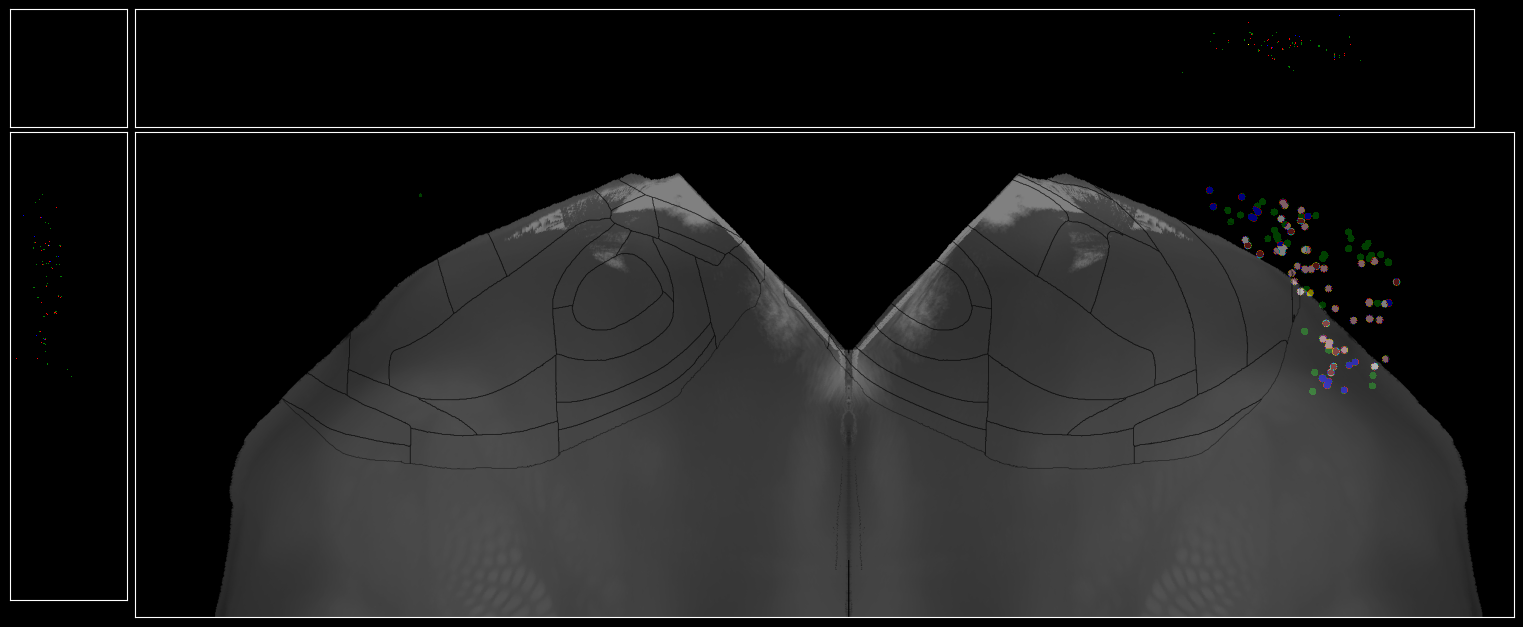

In [9]:
%%time
morphological_list = morphological_dict["unnormalized"] # unnormalized, normalized_layers, normalized_full
label_image = create_label_images(morphological_list)
top_left_images = create_top_left_images(morphological_list)
top_image = np.fliplr(top_left_images["top"])
left_image = top_left_images["left"]

plt.style.use('dark_background')
label_cmap = ListedColormap(['black', 'green', 'red', 'blue', 'orange', 'yellow', 'purple', 'pink', 'cyan', 'brown', 'white'])

fig, axes = setup_main_plot()
axes = plot_boundaries(axes, bf_left_boundaries, bf_right_boundaries)
color_map_template = "Greys_r"
color_map = "Dark2_r"

dilated_image = label_image.copy()
mid_point = dilated_image.shape[1] // 2
end_point = dilated_image.shape[1]
dilated_image[:, 0:mid_point] = expand_label_image(dilated_image[:, 0:mid_point], 6)
dilated_image[:, mid_point:end_point] = expand_label_image(dilated_image[:, mid_point:end_point], 3)
dilated_image = np.fliplr(dilated_image)

axes[1, 1].imshow(bf_projection_max.T, cmap=color_map_template, alpha=1.0, interpolation=None)
ax = axes[1, 1].imshow(dilated_image, cmap=label_cmap, alpha=0.5, interpolation=None)

axes[0, 1].imshow(top_image, cmap=label_cmap, alpha=1.0, interpolation=None)
axes[1, 0].imshow(left_image, cmap=label_cmap, alpha=1.0, interpolation=None)

0
0
0
1
0
0
CPU times: total: 3.48 s
Wall time: 3.5 s


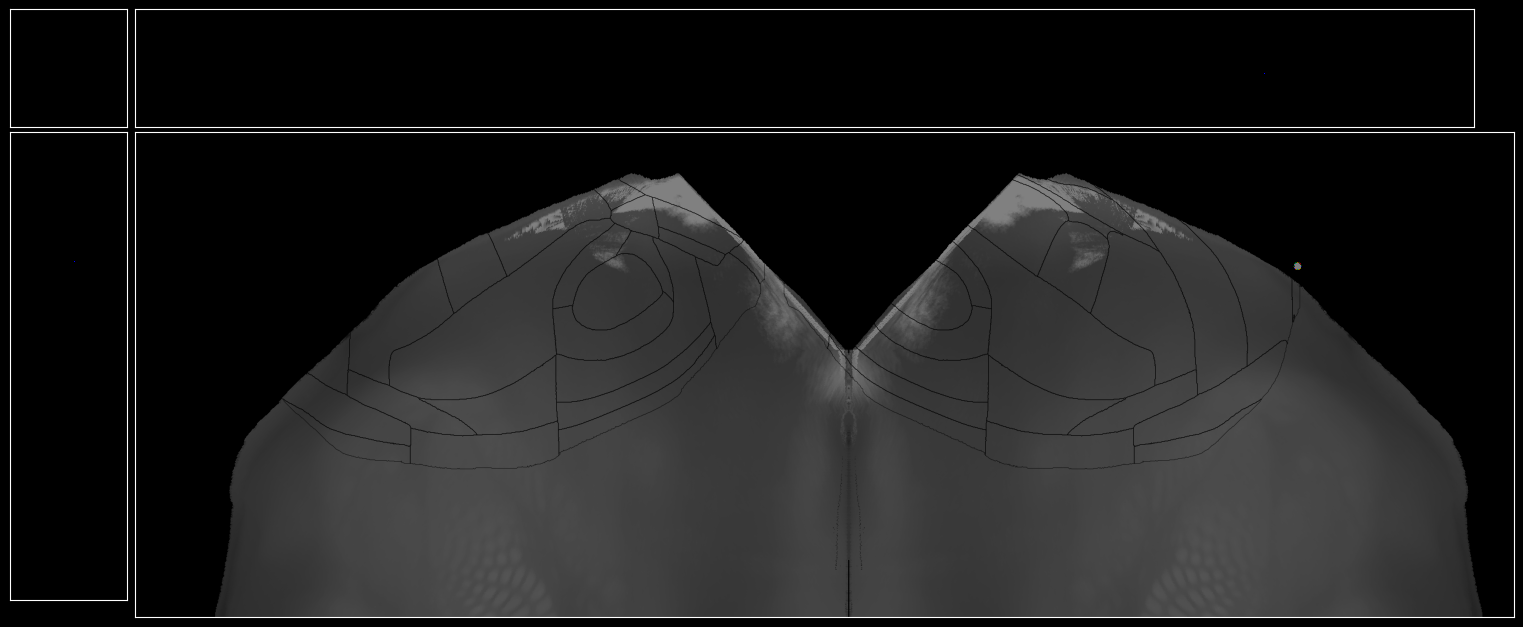

In [10]:
%%time
morphological_list = morphological_dict["normalized_layers"] # unnormalized, normalized_layers, normalized_full
label_image = create_label_images(morphological_list)
top_left_images = create_top_left_images(morphological_list)
top_image = np.fliplr(top_left_images["top"])
left_image = top_left_images["left"]

plt.style.use('dark_background')
label_cmap = ListedColormap(['black', 'green', 'red', 'blue', 'orange', 'yellow', 'purple', 'pink', 'cyan', 'brown', 'white'])

fig, axes = setup_main_plot()
axes = plot_boundaries(axes, bf_left_boundaries, bf_right_boundaries)
color_map_template = "Greys_r"
color_map = "Dark2_r"

dilated_image = label_image.copy()
mid_point = dilated_image.shape[1] // 2
end_point = dilated_image.shape[1]
dilated_image[:, 0:mid_point] = expand_label_image(dilated_image[:, 0:mid_point], 6)
dilated_image[:, mid_point:end_point] = expand_label_image(dilated_image[:, mid_point:end_point], 3)
dilated_image = np.fliplr(dilated_image)

axes[1, 1].imshow(bf_projection_max.T, cmap=color_map_template, alpha=1.0, interpolation=None)
ax = axes[1, 1].imshow(dilated_image, cmap=label_cmap, alpha=0.5, interpolation=None)

axes[0, 1].imshow(top_image, cmap=label_cmap, alpha=1.0, interpolation=None)
axes[1, 0].imshow(left_image, cmap=label_cmap, alpha=1.0, interpolation=None)

0
0
0
1
0
0
CPU times: total: 3.56 s
Wall time: 3.56 s


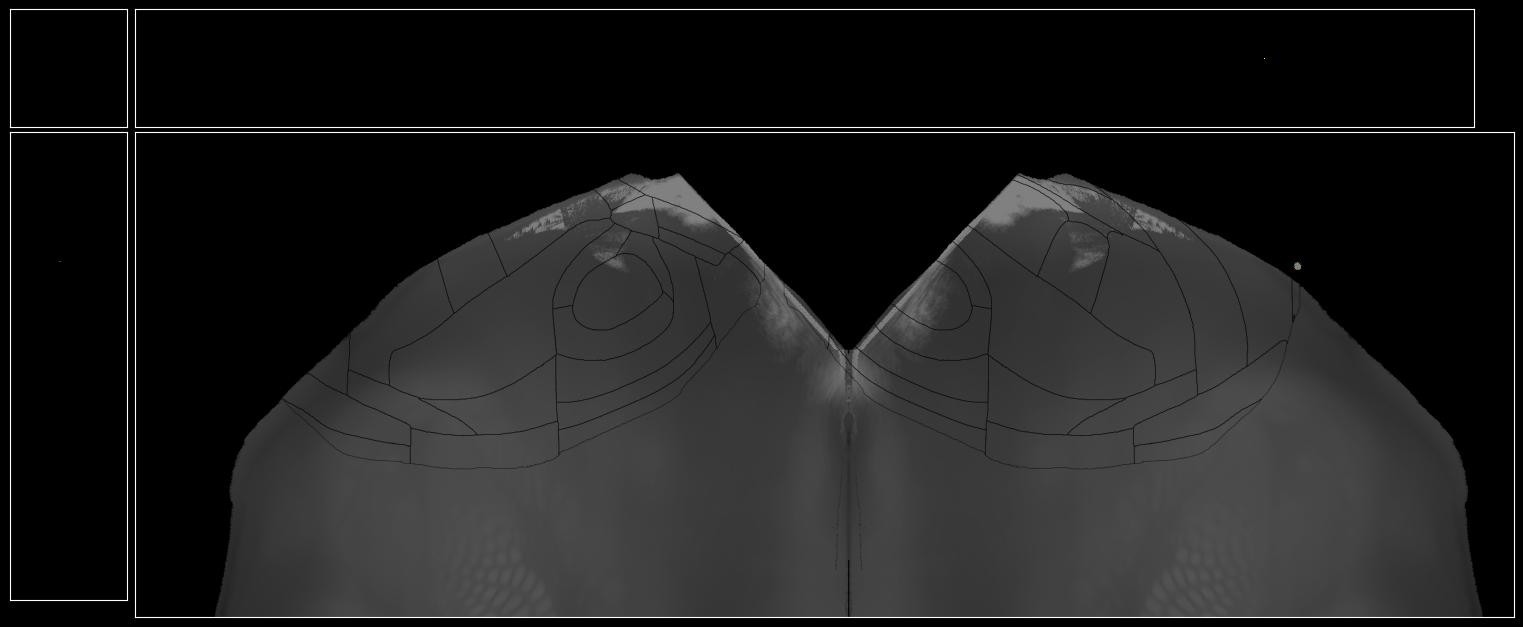

In [11]:
%%time
morphological_list = morphological_dict["normalized_full"] # unnormalized, normalized_layers, normalized_full
label_image = create_label_images(morphological_list)
top_left_images = create_top_left_images(morphological_list)
top_image = np.fliplr(top_left_images["top"])
left_image = top_left_images["left"]

plt.style.use('dark_background')
label_cmap = ListedColormap(['black', 'green', 'red', 'blue', 'orange', 'yellow', 'purple', 'pink', 'cyan', 'brown', 'white'])

fig, axes = setup_main_plot()
axes = plot_boundaries(axes, bf_left_boundaries, bf_right_boundaries)
color_map_template = "Greys_r"
color_map = "Dark2_r"

dilated_image = label_image.copy()
mid_point = dilated_image.shape[1] // 2
end_point = dilated_image.shape[1]
dilated_image[:, 0:mid_point] = expand_label_image(dilated_image[:, 0:mid_point], 6)
dilated_image[:, mid_point:end_point] = expand_label_image(dilated_image[:, mid_point:end_point], 3)
dilated_image = np.fliplr(dilated_image)

axes[1, 1].imshow(bf_projection_max.T, cmap=color_map_template, alpha=1.0, interpolation=None)
ax = axes[1, 1].imshow(dilated_image, cmap=label_cmap, alpha=0.5, interpolation=None)

axes[0, 1].imshow(top_image, cmap=label_cmap, alpha=1.0, interpolation=None)
axes[1, 0].imshow(left_image, cmap=label_cmap, alpha=1.0, interpolation=None)